<a href="https://colab.research.google.com/github/Bepitic/Data-Analytics/blob/main/DA_assig-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import statistics
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition, datasets
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/bottle.csv')

<ipython-input-3-a476024399dc>:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/bottle.csv')


In [ ]:
# just to get some INFO FOR REPORT, REMOVE IT.
print(len(df))
print(len(df.columns))
nul = df.isnull().sum() / len(df)
nul = nul[nul>0]
nul = nul.sort_values(ascending = False)
nul

qual_cols = df.filter(regex='_qual$|qua$|q$')

# Calculate the percentage of null values for each column
null_percentages = qual_cols.isnull().mean() * 100

# Print the percentage of null values for each column
print(null_percentages)

864863
74
T_qual    97.325935
S_qual    91.338050
P_qual    22.096910
O_qual    78.646791
SThtaq    92.389199
O2Satq    74.817168
Chlqua    26.096272
Phaqua    26.095809
PO4q      47.762131
NO2q      38.779437
NO3q      38.726365
NH3q       6.540227
C14A1q     1.879835
C14A2q     1.877754
DarkAq     2.823915
MeanAq     2.824031
dtype: float64


In [ ]:
# @title Notes / TODO
# Add a tranformation to the depth and make Log(depth)

# Add 2 one-hot encoding for the month and the year

# Read More about outliers in our case
# the Mahalanobis distance / the treeoutliers.
# if it is for both then is an outlier

# Use Models Xgboost Random-Forest MultiLinearRegression
# Plot Different loss function


In [ ]:
#@title Functions(Paco)
def fill_null_values_by_previous(data):
    data.fillna(method='ffill', inplace=True)
    return data

def fill_null_values_by_next(data):
    data.fillna(method='bfill', inplace=True)
    return data

#TODO:
def add_one_hot_enc(data,column):
    pass



In [ ]:
#@title Functions(Shega)
def describe(data):
    return data.describe()

def check_quality_control_columns(data):
    qual_cols = data.filter(regex='_qual$|qua$|q$')
    return qual_cols.columns, qual_cols

def check_reported_control_columns(data):
    reported_cols = data.filter(regex='^R_.*')
    return reported_cols.columns

def drop_quality_control_columns(data, qual_cols_columns):
    # drop columns and rows with a quality column not null
    #qual_col,_ = check_quality_control_columns(df)
    #data = df
    #mask = data[qual_col].fillna(0) == 0
    #print(mask)
    #print(mask.all(axis=1).sum())
    data = data[ data[[qual_cols_columns]].fillna(0) != 0]
    return data.drop(columns= qual_cols_columns)

def drop_reported_columns(data, reported_columns):
    return data.drop(columns = reported_columns)

def check_columns_for_null_percentage(data_with_null):
    null_percentage = data_with_null.isnull().sum() / len(data_with_null) * 100
    return null_percentage.sort_values(ascending=True)

def drop_columns_by_null_percentage(data, null_percentage, threshold):
    cols_to_drop = null_percentage[null_percentage > threshold].index
    return data.drop(cols_to_drop, axis=1)

def fill_null_values_by_mode(data):
    for column in data:
        if data[column].isnull().sum() > 0:
            # Calculate the mode of the column and fill in missing values with the mode value
            mode_value = data[column].mode().mean()
            data[column].fillna(mode_value, inplace=True)
    return data

def fill_null_values_by_median(data):
    for column in data:
        if data[column].isnull().sum() > 0:
            # Calculate the median of the column and fill in missing values with the median value
            median_value = data[column].median()
            data[column].fillna(median_value, inplace=True)
    return data

def normalize_columns(data_to_normalize):
    data_to_normalize = data_to_normalize.drop(columns=["Cst_Cnt","Btl_Cnt","Sta_ID","Depth_ID"], errors='ignore')
    normalized_data = MinMaxScaler().fit_transform(data_to_normalize)
    df_norm = pd.DataFrame(normalized_data, index=data_to_normalize.index, columns=data_to_normalize.columns)
    return df_norm


def standardized_columns(data_to_standardized):
    data_to_standardized = data_to_standardized.drop(columns=["Cst_Cnt","Btl_Cnt","Sta_ID","Depth_ID"], errors='ignore')
    normalized_data = StandardScaler().fit_transform(data_to_standardized)
    df_norm = pd.DataFrame(normalized_data, index=data_to_standardized.index, columns=data_to_standardized.columns)
    return df_norm


def remove_duplicates(data):
    duplicates = data.duplicated()
    print(duplicates)
    return data.drop_duplicates()


def calculate_pearson_correlation(data, column_to_check):
    print("Pearson Correlation")
    correlation_matrix = data.corr()
    correlation_with_column = correlation_matrix[column_to_check].sort_values(ascending=False)
    # Get the top 4 highest correlations
    # top_correlations = corr_with_t_degC[1:5]
    top_correlations = correlation_with_column
    for column in top_correlations.index:
        plt.figure()
        plt.scatter(data[column], data[column_to_check])
        plt.xlabel(column)
        plt.ylabel(column_to_check)
        plt.title('Pearson Correlation between: {} and {}'.format(column, column_to_check))
        file_name = re.sub('[^A-Za-z0-9]+', '', column+'and'+column_to_check)
        plt.savefig('pearson_corr/{}.png'.format(file_name))
        plt.close()
    return top_correlations

def calculate_spearman_correlation(data, column_to_check):
    print("Spearman Correlation")
    correlation_matrix = data.corr(method='spearman')
    correlation_with_column = correlation_matrix[column_to_check].sort_values(ascending=False)
    # Get the top 4 highest correlations
    # top_correlations = corr_with_t_degC[1:5]

    # In this case we got all the corrections
    top_correlations = correlation_with_column
    for column in top_correlations.index:
        plt.figure()
        plt.scatter(data[column], data[column_to_check])
        plt.xlabel(column)
        plt.ylabel(column_to_check)
        plt.title('Spearman Correlation between: {} and {}'.format(column, column_to_check))
        file_name = re.sub('[^A-Za-z0-9]+', '', column+'and'+column_to_check)
        plt.savefig('spearman_corr/{}.png'.format(file_name))
        plt.close()
    return top_correlations

def show_all_data_histograms(data, with_quality_columns=True):
    if with_quality_columns is False:
        qual_cols = data.filter(regex='_qual$|qua$|q$')
        data_new = data.drop(columns=qual_cols.columns)
        for column in data_new.columns:
            if column in ['Cst_Cnt','Btl_Cnt','Sta_ID','Depth_ID']:
                continue
            else:
                plt.figure()
                plt.hist(data_new[column], bins=20)
                plt.title(column)
                # save the plot to the "plots" folder
                file_name = re.sub('[^A-Za-z0-9]+', '', column)
                plt.savefig('histograms/{}.png'.format(file_name))
                plt.close()
    else:
        for column in data.columns:
            if column in ['Cst_Cnt','Btl_Cnt','Sta_ID','Depth_ID']:
                continue
            else:
                plt.figure()
                plt.hist(data_new[column], bins=20)
                plt.title(column)
                # save the plot to the "plots" folder
                file_name = re.sub('[^A-Za-z0-9]+', '', column)
                plt.savefig('histograms/{}.png'.format(file_name))
                plt.close()


In [ ]:
#@title Outliers management
from scipy.stats import chi2

#definition: Distance between two given points provided that they are in multivariate space.
def calculateMahalanobis(y=None, data=None, cov=None):
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)

    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()
def calculate_P_value(data,num_columns):
  deg = num_columns - 1
  df['p'] = 1 - chi2.cdf(df['Mahalanobis'], deg)
  # less than 0.001 are considered outliers!


In [ ]:
#@title Pre-process the dataset
null_percentage_cut = 40 #@param
#@markdown Input __df__  <-"dataset"
#@markdown
#@markdown _Output_ __df_median__  <- "null filled with median"
#@markdown
#@markdown _Output_ __df_mode__  <- "null filled with mode"

# Remove all quality control columns
# q_col,_ = check_quality_control_columns(df)
# df = drop_reported_columns(df,q_col) # not working

# Remove all reported control columns
col = check_reported_control_columns(df)
df1 = drop_reported_columns(df,col)

qual_col,_ = check_quality_control_columns(df1)
df1[qual_col] = df1[qual_col].fillna(0)
df2 = drop_columns_by_null_percentage(
    df1,check_columns_for_null_percentage(df1),null_percentage_cut
    )

# corr = df2.corr()
# plt.figure(figsize = (20,10))
# sns.heatmap(corr, annot = True)


df2['count_nines'] = df2[qual_col].apply(lambda row: (row == 9).sum(), axis=1)
df2 = df2[df2['count_nines'] <= 10]


df2 = df2.drop(columns=['Cst_Cnt','Btl_Cnt','Depth_ID','Sta_ID'], errors='ignore')
# df2 = df2.drop(columns=["Depthm"])


df_bfill = fill_null_values_by_previous(df2)
df_ffill = fill_null_values_by_next(df2)

df_mode = fill_null_values_by_mode(df2)
df_median = fill_null_values_by_median(df2)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)


In [ ]:
#@title Process(split) the dataset to train the models.
df1 = df_mode #@param ["df_median", "df_mode", "df_mode_std", "df_median_std", "df_mode_norm", "df_median_norm", "df_bfill", "df_ffill", "None"] {type:"raw"}



train, validation, test = np.split(df1, [int(.8 * len(df1)), int(.9 * len(df1))])


def split_XY(dataset,label_column="T_degC"):
  df_label = dataset.loc[:,label_column]
  df_X = dataset.drop(columns=[label_column])
  return (df_X, df_label)


trainxy = split_XY(train)
validationxy = split_XY(validation)
testxy = split_XY(test)


def preprocess(df1):

  train, validation, test = np.split(df1, [int(.8 * len(df1)), int(.9 * len(df1))])


  def split_XY(dataset,label_column="T_degC"):
    df_label = dataset.loc[:,label_column]
    df_X = dataset.drop(columns=[label_column])
    return (df_X, df_label)


  trainxy = split_XY(train)
  validationxy = split_XY(validation)
  testxy = split_XY(test)
  return trainxy,validationxy,testxy

In [ ]:
# trainxy[0] is X
# trainxy[1] is Y or Labels

## Models

In [ ]:
# #@title Models (xgboost).
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import get_scorer_names

# print(get_scorer_names())
# # scores = cross_val_score(XGBRegressor(), trainxy[0], trainxy[1])

# xgbr = XGBRegressor(verbosity=0)
# xgbr.fit(trainxy[0], trainxy[1])
# scores = cross_val_score(xgbr, trainxy[0], trainxy[1])
# print("Mean cross-validation score: %.2f" % scores.mean())


# from sklearn.metrics import mean_squared_error

# ypred = xgbr.predict(testxy[0])
# mse = mean_squared_error(testxy[1], ypred)
# print("MSE: %.8f" % mse)


['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [ ]:
# print(testxy[0])

23.377323
23.261


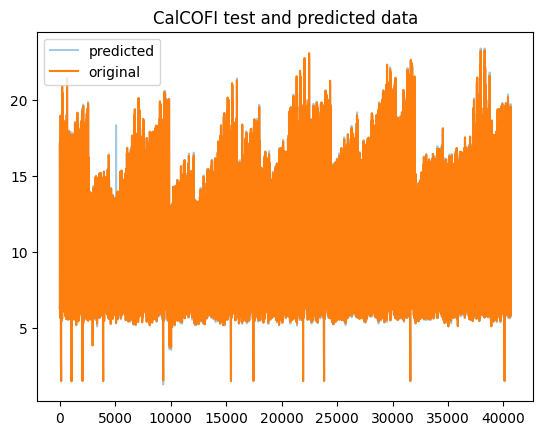

In [ ]:
# #@title testing the model
# # print("Describe the data")
# # html = "<div style='overflow-x: auto;'><table>{}</table></div>".format(describe(df1).to_html())
# # display(HTML(html))

# x_ax = range(len(testxy[1]))
# print(ypred.max())
# print(testxy[1].max())
# # plt.plot(x_ax, ypred, label="predicted")
# # plt.plot(x_ax, testxy[1], label="original")
# plt.plot(x_ax, ypred, label="predicted", alpha=0.4)
# plt.plot(x_ax, testxy[1], label="original", alpha=1)


# # plt.plot(x_ax, ypred, label="predicted")
# plt.title("CalCOFI test and predicted data")
# plt.legend()
# plt.show()




In [ ]:
#@title Models (Linear Regression).


In [ ]:
# print("Describe the data")
# html = "<div style='overflow-x: auto;'><table>{}</table></div>".format(describe(df_mode).to_html())
# display(HTML(html))

# print(df_mode.columns)

In [ ]:
# #@title Models (RandomForestRegressor).

# from sklearn.ensemble import RandomForestRegressor

# model_random_forest = RandomForestRegressor()

# model_random_forest.fit(trainxy[0], trainxy[1])

# ypred = model_random_forest.predict(testxy[0])
# mse = mean_squared_error(testxy[1], ypred)
# print("MSE: %.8f" % mse)


MSE: 0.00716612


In [ ]:
# #@title Models (linear Regression)

# from sklearn.linear_model import LinearRegression

# model_lr = LinearRegression()
# model_lr.fit(trainxy[0], trainxy[1])

# ypred = model_lr.predict(testxy[0])
# mse = mean_squared_error(testxy[1], ypred)
# print(f"MSE: {mse:8f}")
# print("MSE: %.8f" % mse)

MSE: 0.032599
MSE: 0.03259875


##Models Automated:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape


def models_automated(trainxy, testxy, name='CalCOFI'):

  model_lr = LinearRegression()
  model_lr.fit(trainxy[0], trainxy[1])

  ypred = model_lr.predict(testxy[0])
  mse_linear = mse(testxy[1], ypred)
  mae_linear = mae(testxy[1], ypred)
  mape_linear = mape(testxy[1], ypred)
  print(f"Model,dataset,mse,mae,mape")
  print(f"Linear,{name},{mse_linear:10f},{mae_linear:10f},{mape_linear:10f}")

  model_random_forest = RandomForestRegressor()

  model_random_forest.fit(trainxy[0], trainxy[1])

  ypred = model_random_forest.predict(testxy[0])
  mse_rf = mse(testxy[1], ypred)
  mae_rf = mae(testxy[1], ypred)
  mape_rf = mape(testxy[1], ypred)
  print(f"RandomForest,{name},{mse_rf:10f},{mae_rf:10f},{mape_rf:10f}")

  xgbr = XGBRegressor(verbosity=0)
  xgbr.fit(trainxy[0], trainxy[1])
  ypred = xgbr.predict(testxy[0])
  mse_xg = mse(testxy[1], ypred)
  mae_xg = mae(testxy[1], ypred)
  mape_xg = mape(testxy[1], ypred)
  print(f"Xgboost,{name},{mse_xg:10f},{mae_xg:10f},{mape_xg:10f}")



In [ ]:
# df_mode = fill_null_values_by_mode(df2)
# df_median = fill_null_values_by_median(df2)
# df_mode_std = standardized_columns(df_mode)
# df_median_std = standardized_columns(df_median)
# df_mode_norm = normalize_columns(df_mode)
# df_median_norm = normalize_columns(df_median)
# tr,vl,te=preprocess(df2)
# models_automated(tr,vl,"untouch")

tr,vl,te=preprocess(df_median)
models_automated(tr,vl,"median")

tr,vl,te=preprocess(df_median_std)
models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

tr,vl,te=preprocess(df_mode)
models_automated(tr,vl,"mode")
tr,vl,te=preprocess(df_mode_std)
models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")



Model,dataset,mse,mae,mape
Linear,median,0.0811789371,0.2097445411,0.0228753147
RandomForest,median,0.0017254502,0.0102549985,0.0010269099
Xgboost,median,0.0052191007,0.0507385706,0.0050040325
Model,dataset,mse,mae,mape
Linear,median_std,0.0048724648,0.0513858259,0.3122633300
RandomForest,median_std,0.0000959128,0.0024980752,0.0189783157
Xgboost,median_std,0.0003055856,0.0122827458,0.1011665273
Model,dataset,mse,mae,mape
Linear,median_norm,0.0000968604,0.0072450619,0.0340277178
RandomForest,median_norm,0.0000020637,0.0003679852,0.0016225824
Xgboost,median_norm,0.0000060539,0.0016865783,0.0059784546
Model,dataset,mse,mae,mape
Linear,mode,0.0811789371,0.2097445411,0.0228753147
RandomForest,mode,0.0017214816,0.0104816689,0.0010444196
Xgboost,mode,0.0052191007,0.0507385706,0.0050040325
Model,dataset,mse,mae,mape
Linear,mode_std,0.0048724648,0.0513858259,0.3122633300
RandomForest,mode_std,0.0001082885,0.0026419197,0.0256031263
Xgboost,mode_std,0.0003055856,0.0122827458,0.1011665273
Model,da

In [ ]:
# Without the depth
df3 = df2.drop(columns=["Depthm"])


df_bfill = fill_null_values_by_previous(df3)
df_ffill = fill_null_values_by_next(df3)

df_mode = fill_null_values_by_mode(df3)
df_median = fill_null_values_by_median(df3)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)

tr,vl,te=preprocess(df_median)
models_automated(tr,vl,"median")

tr,vl,te=preprocess(df_median_std)
models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

tr,vl,te=preprocess(df_mode)
models_automated(tr,vl,"mode")
tr,vl,te=preprocess(df_mode_std)
models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")


Model,dataset,mse,mae,mape
Linear,median,0.0548498645,0.1676127230,0.0196027235
RandomForest,median,0.0018400183,0.0107916292,0.0010445664
Xgboost,median,0.0058345549,0.0500174080,0.0049468956
Model,dataset,mse,mae,mape
Linear,median_std,0.0032921598,0.0410638492,0.2608796240
RandomForest,median_std,0.0001207509,0.0027598002,0.0243942991
Xgboost,median_std,0.0002998926,0.0118316716,0.0993103522
Model,dataset,mse,mae,mape
Linear,median_norm,0.0000654453,0.0057897314,0.0465686774
RandomForest,median_norm,0.0000024967,0.0003923043,0.0014132241
Xgboost,median_norm,0.0000072279,0.0016265265,0.0060050969
Model,dataset,mse,mae,mape
Linear,mode,0.0548498645,0.1676127230,0.0196027235
RandomForest,mode,0.0018838138,0.0110008680,0.0010663428
Xgboost,mode,0.0058345549,0.0500174080,0.0049468956
Model,dataset,mse,mae,mape
Linear,mode_std,0.0032921598,0.0410638492,0.2608796240
RandomForest,mode_std,0.0001469025,0.0028428064,0.0234757937
Xgboost,mode_std,0.0002998926,0.0118316716,0.0993103522
Model,da

In [ ]:
df2.columns
df2[['T_degC','Salnty','STheta','O2Sat']]

Index(['Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat',
       'Oxy_µmol/Kg', 'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual',
       'P_qual', 'O_qual', 'SThtaq', 'O2Satq', 'Chlqua', 'Phaqua', 'PO4q',
       'NO2q', 'NO3q', 'NH3q', 'C14A1q', 'C14A2q', 'DarkAq', 'MeanAq'],
      dtype='object')

In [ ]:
# Without the depth
df3 = df2[['T_degC','Salnty','STheta','O2Sat']]


#df_bfill = fill_null_values_by_previous(df3)
#df_ffill = fill_null_values_by_next(df3)

df_mode = fill_null_values_by_mode(df3)
df_median = fill_null_values_by_median(df3)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)

tr,vl,te=preprocess(df_median)
models_automated(tr,vl,"median")

tr,vl,te=preprocess(df_median_std)
models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

tr,vl,te=preprocess(df_mode)
models_automated(tr,vl,"mode")
tr,vl,te=preprocess(df_mode_std)
models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")


<ipython-input-106-9bddd39d847e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)
<ipython-input-106-9bddd39d847e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='bfill', inplace=True)


Model,dataset,mse,mae,mape
Linear,median,0.0834381647,0.2190907084,0.0256400933
RandomForest,median,0.0011732203,0.0079914160,0.0007923688
Xgboost,median,0.0046537485,0.0478306503,0.0047846834
Model,dataset,mse,mae,mape
Linear,median_std,0.0050080666,0.0536755662,0.3886876853
RandomForest,median_std,0.0000736345,0.0019740784,0.0152895825
Xgboost,median_std,0.0002731781,0.0116120246,0.0994553062
Model,dataset,mse,mae,mape
Linear,median_norm,0.0000995560,0.0075679001,0.0521249663
RandomForest,median_norm,0.0000014615,0.0002772234,0.0010396857
Xgboost,median_norm,0.0000053620,0.0016287879,0.0058856719
Model,dataset,mse,mae,mape
Linear,mode,0.0834381647,0.2190907084,0.0256400933
RandomForest,mode,0.0012238284,0.0080056684,0.0007959541
Xgboost,mode,0.0046537485,0.0478306503,0.0047846834
Model,dataset,mse,mae,mape
Linear,mode_std,0.0050080666,0.0536755662,0.3886876853
RandomForest,mode_std,0.0000758426,0.0019734867,0.0156018348
Xgboost,mode_std,0.0002731781,0.0116120246,0.0994553062
Model,da

In [ ]:
# # Generate the heatmap, uncomment only in case you need to regenrate the heatmap.

# data = pd.read_csv('/content/drive/My Drive/bottle.csv')
# data = data.drop(columns=['Cst_Cnt','Btl_Cnt','Sta_ID','Depth_ID', 'T_prec', 'S_prec', 'RecInd'])
# corr = data.corr()
# plt.figure(figsize = (20,10))
# sns.heatmap(corr, annot = True)
# plt.savefig('heatmap.png')

In [ ]:

def isolated_forest(data, contamination):
  temp_data = data
  # Initialize Isolation Forest
  isolation_forest = IsolationForest(contamination=contamination, random_state=42)

  # Fit the model and predict outliers
  outliers = isolation_forest.fit_predict(temp_data)

  # Add the outlier predictions as a new column in the DataFrame
  temp_data['outlier'] = outliers


  outliers = temp_data[temp_data['outlier'] == -1]
  inliers = temp_data[temp_data['outlier'] == 1]
  for column in temp_data.columns:
      if column != "outlier":
          fig, ax = plt.subplots(figsize=(12, 6))
          ax.scatter(outliers.index, outliers[column], color='r', label='Outliers', alpha=0.7)
          ax.scatter(inliers.index, inliers[column], label='Inliers', alpha=0.7)

          ax.set_xlabel('Index')
          ax.set_ylabel(column)
          ax.set_title('Inliers and Outliers in {} Column using Isolation Forest'.format(column))
          ax.legend()
          plt.show()
  return outliers, inliers



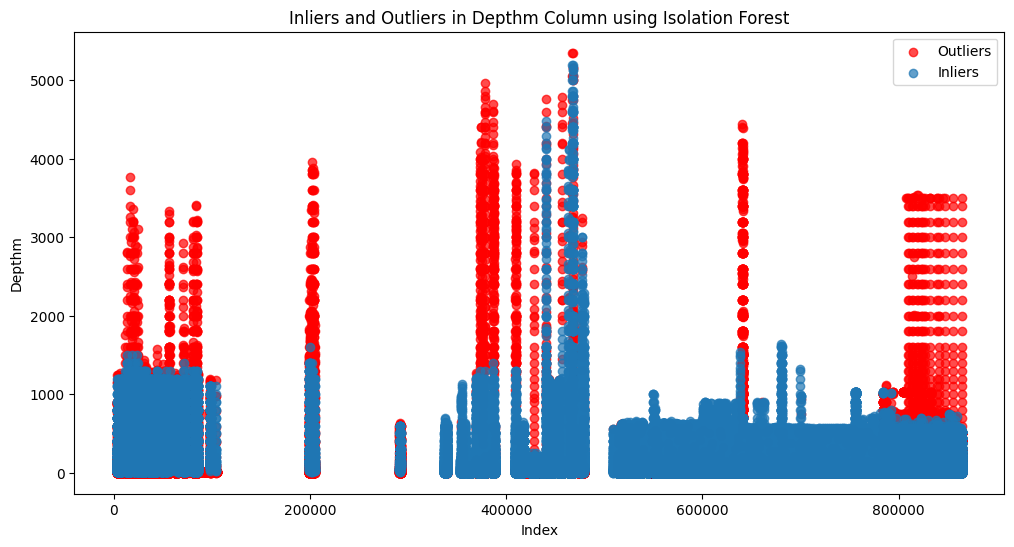

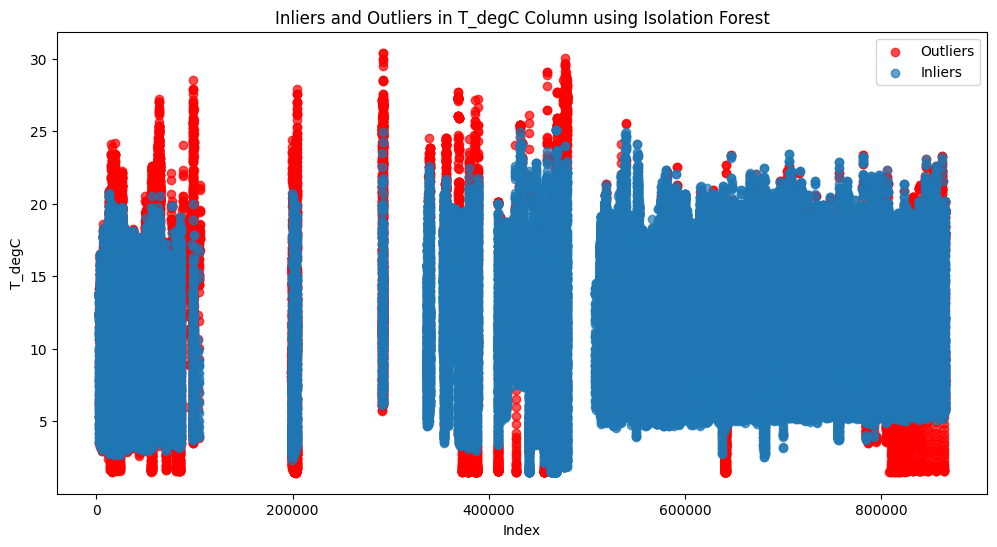

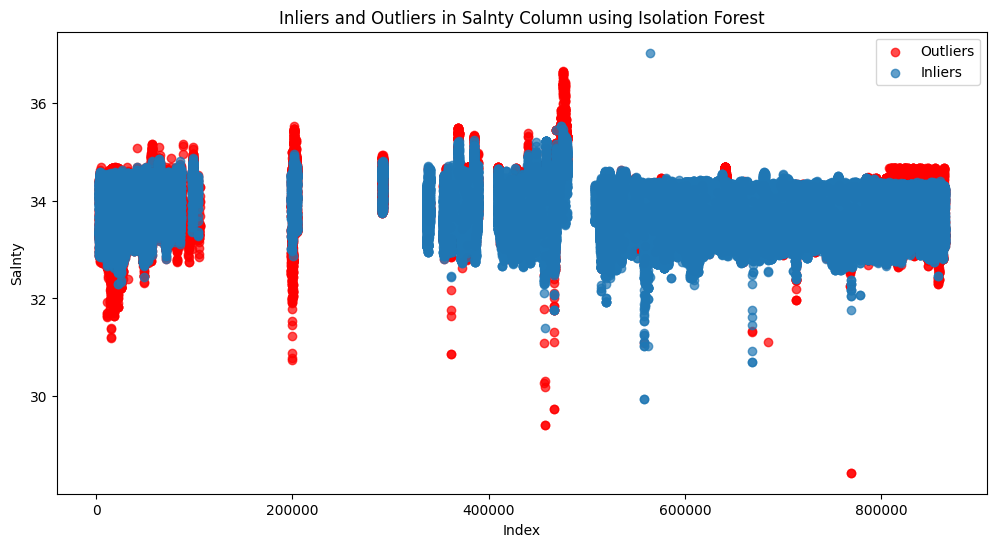

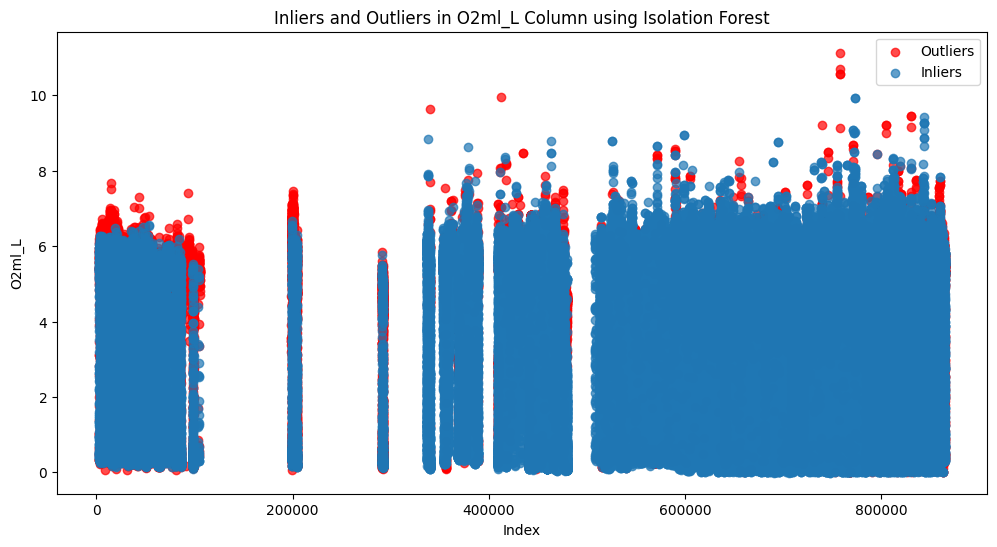

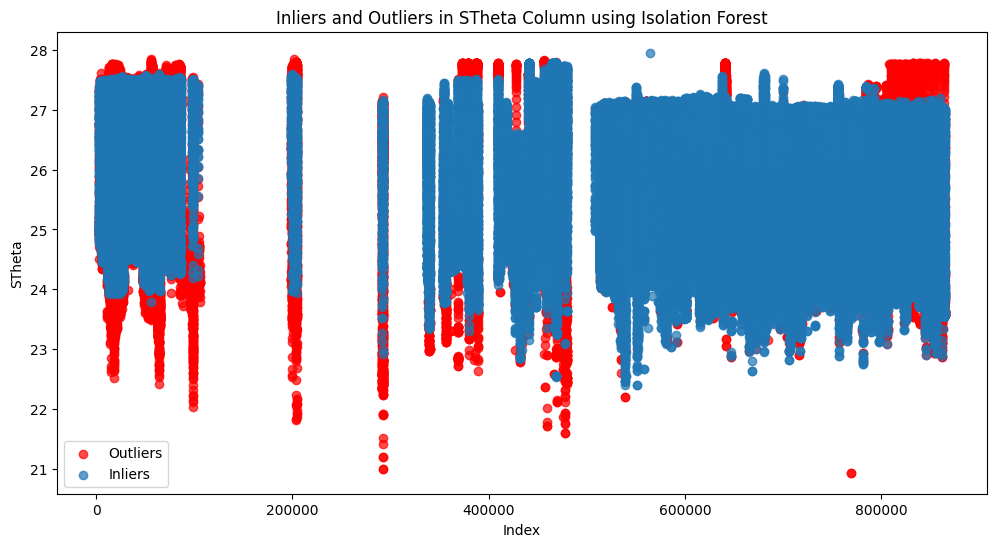

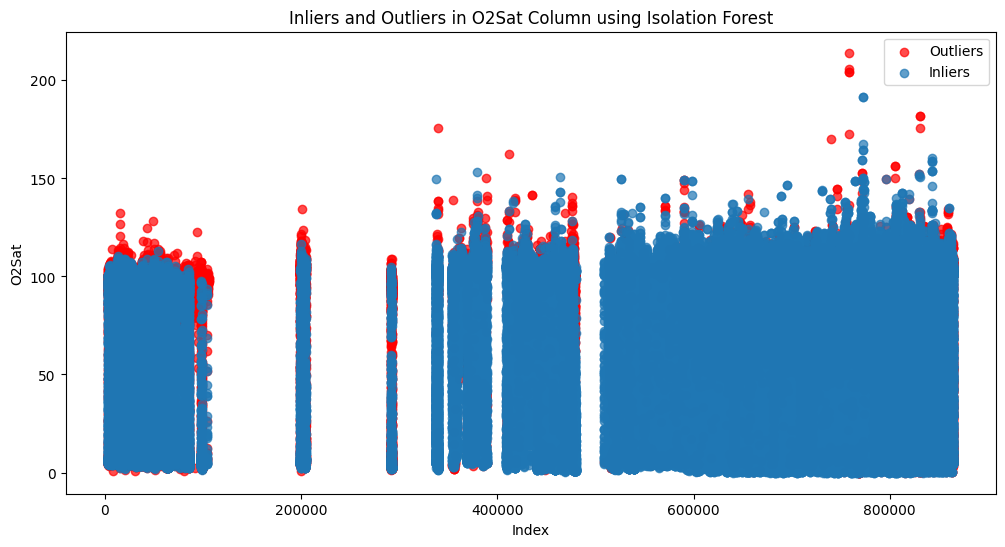

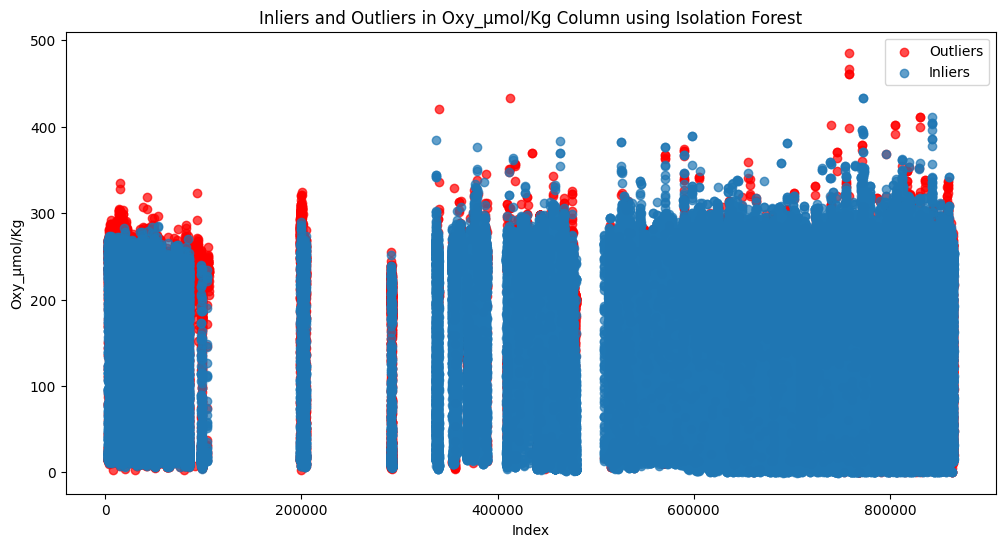

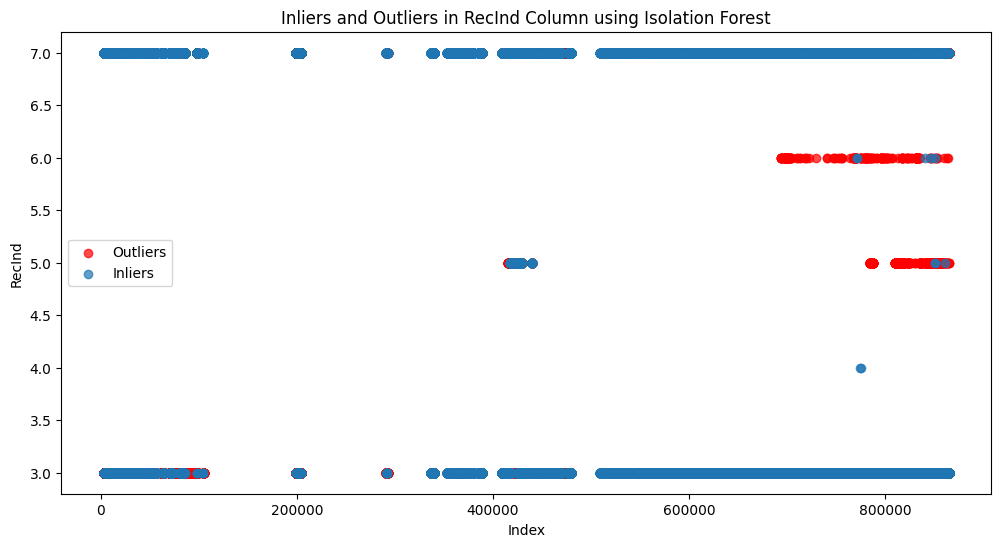

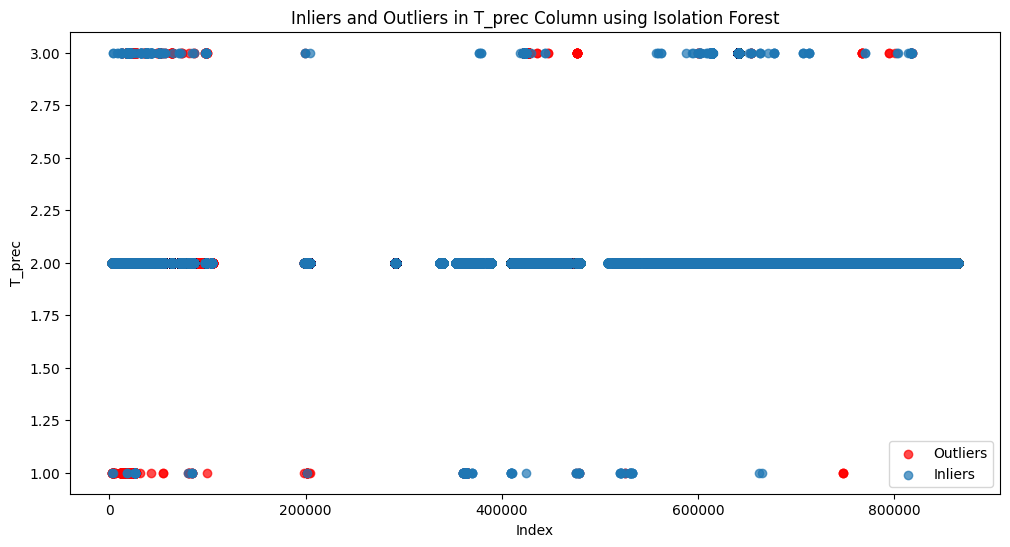

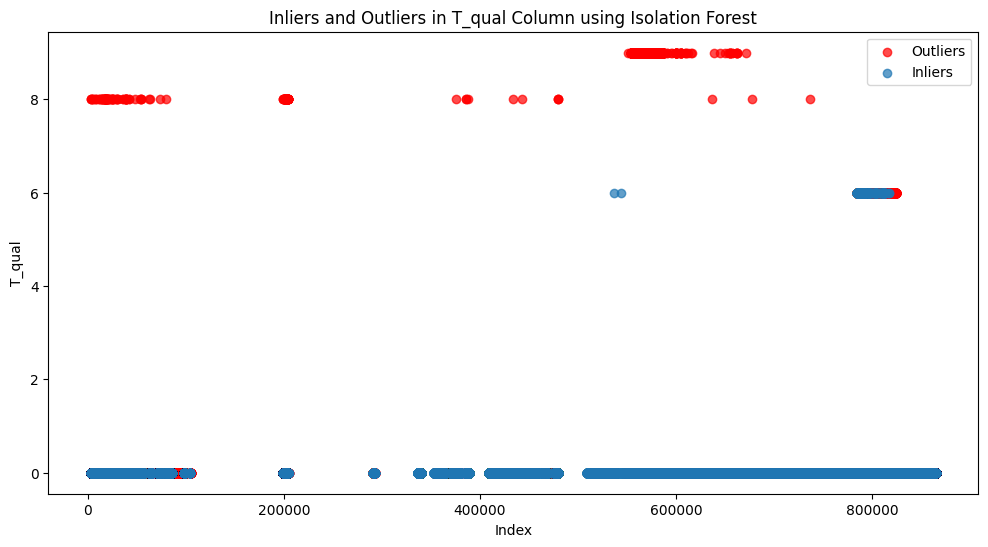

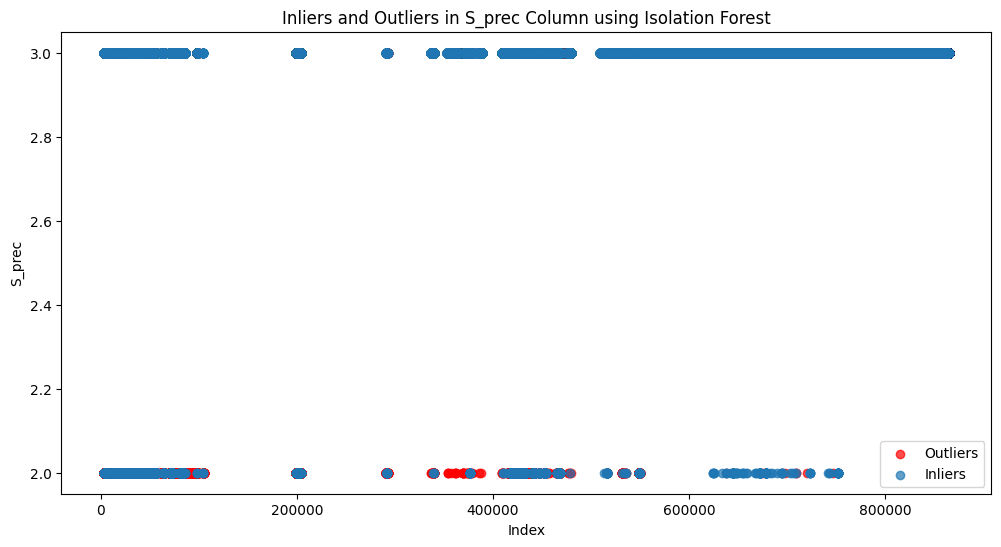

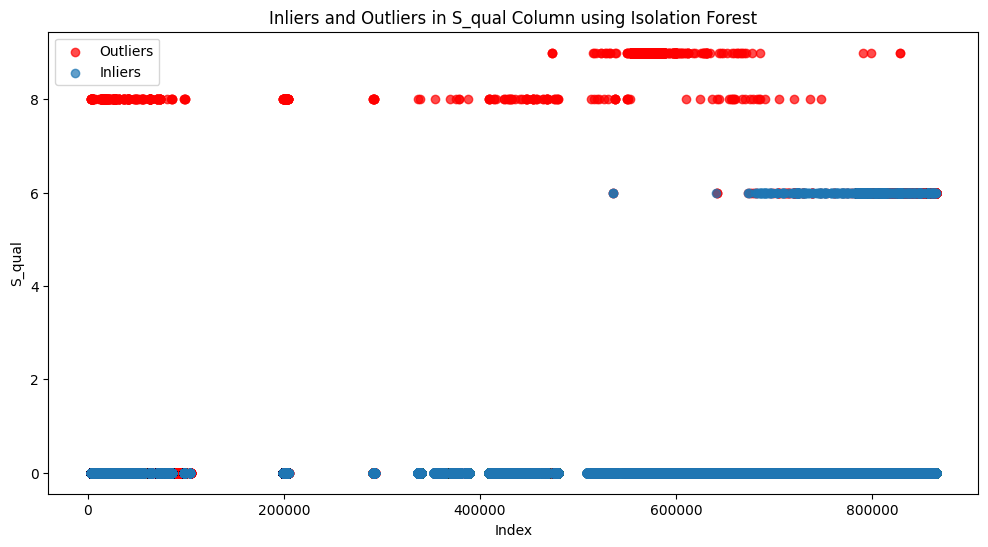

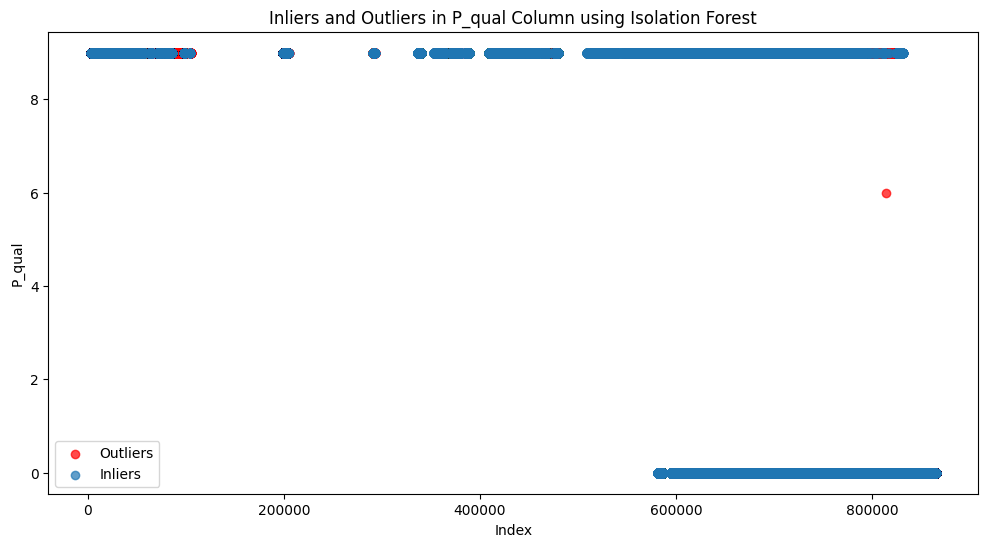

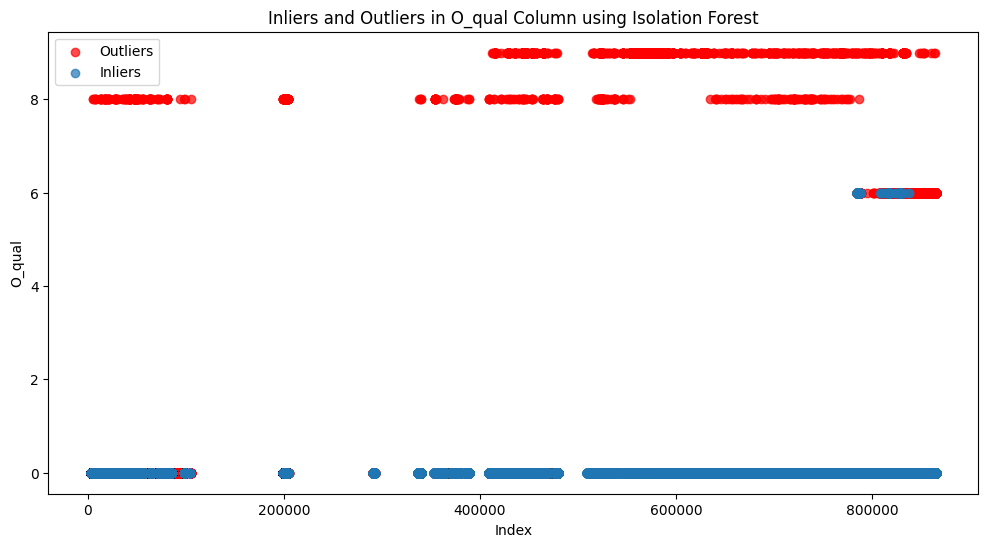

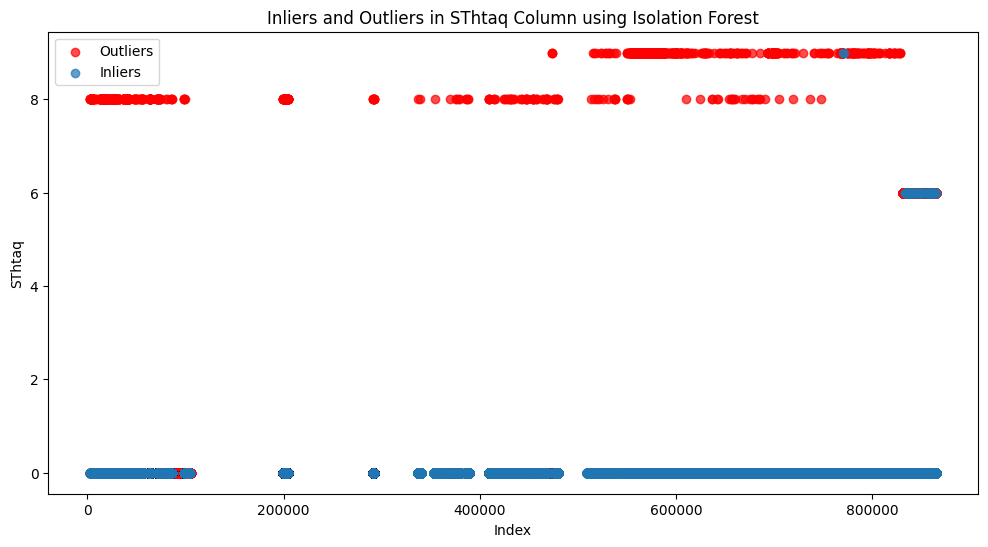

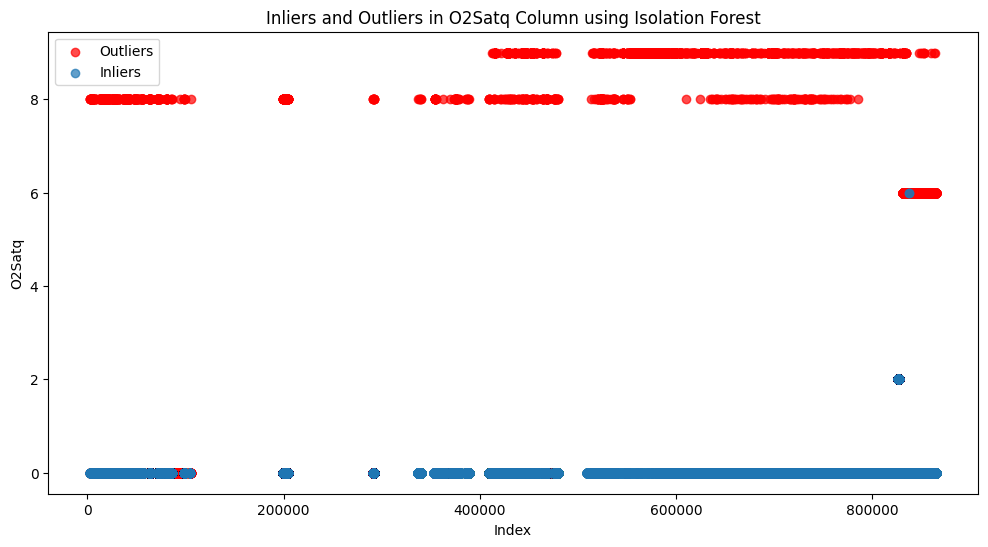

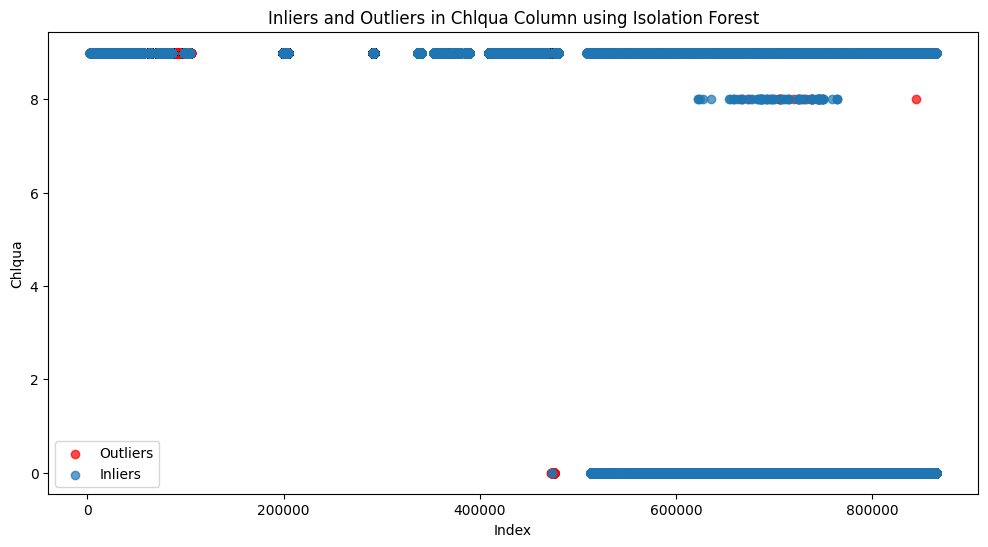

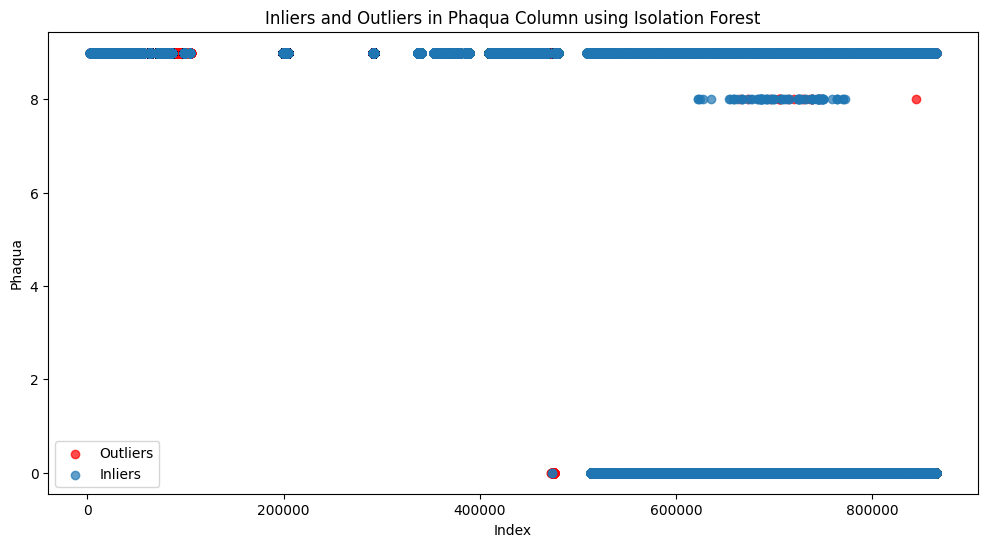

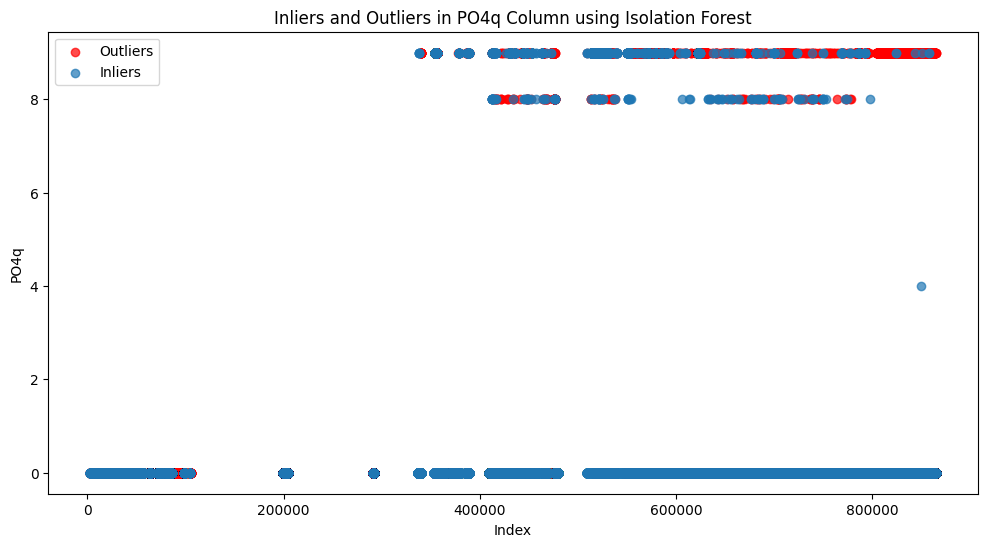

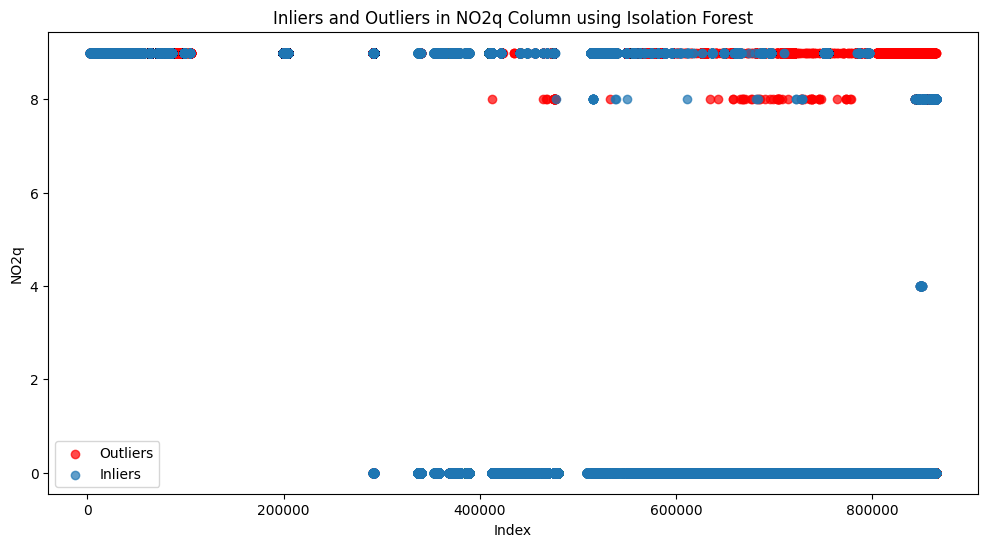

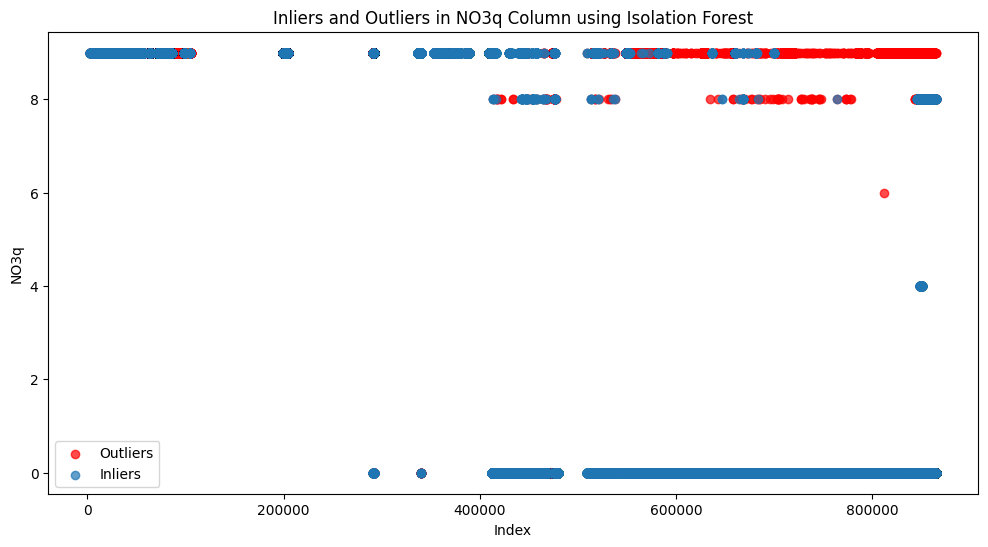

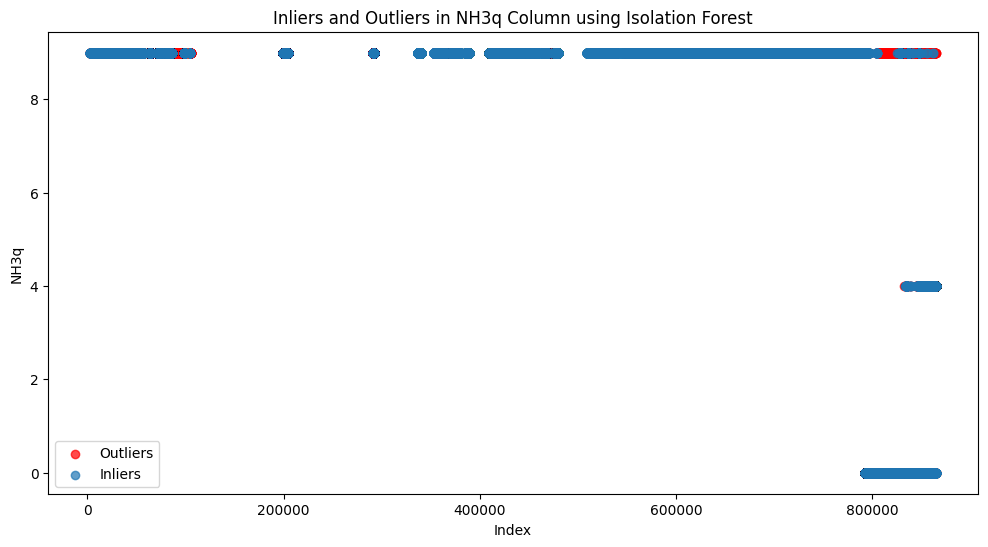

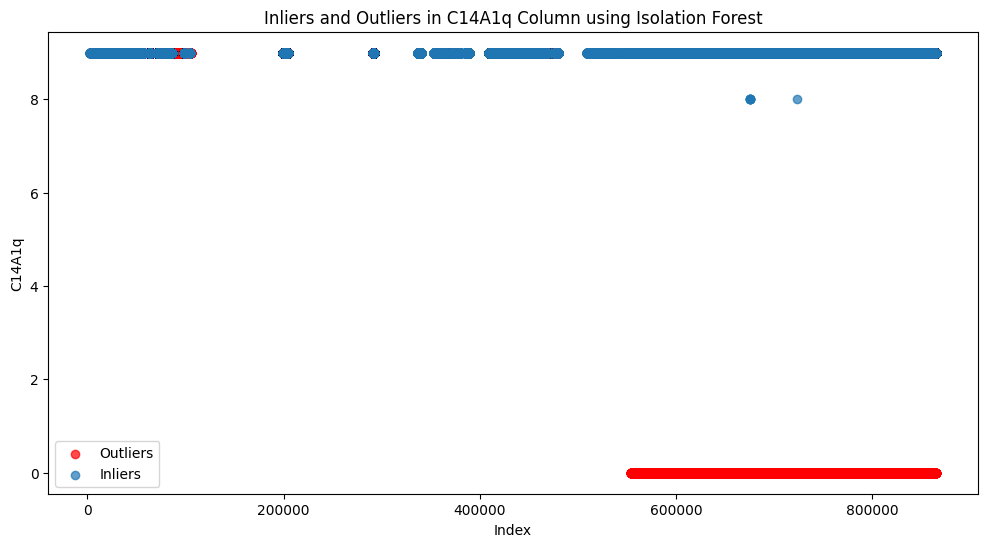

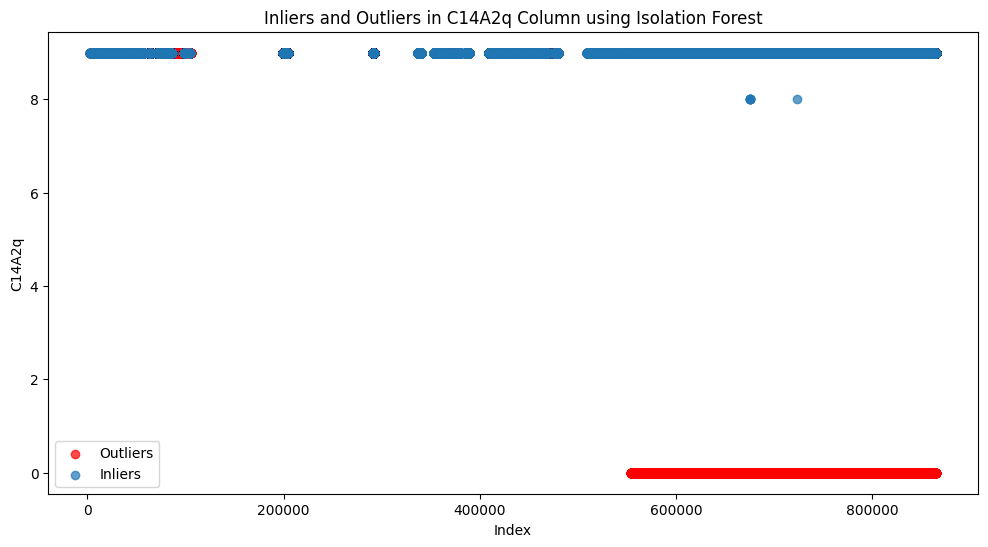

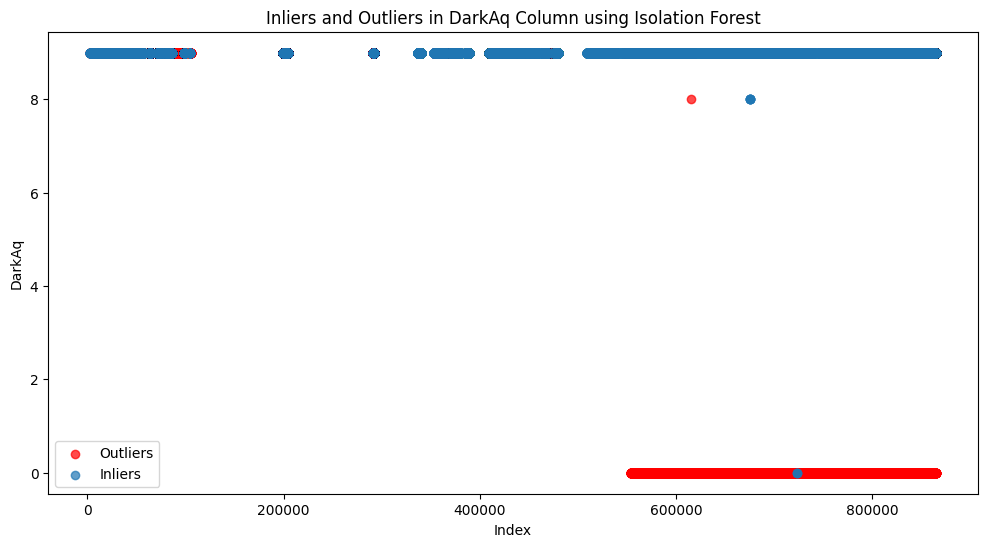

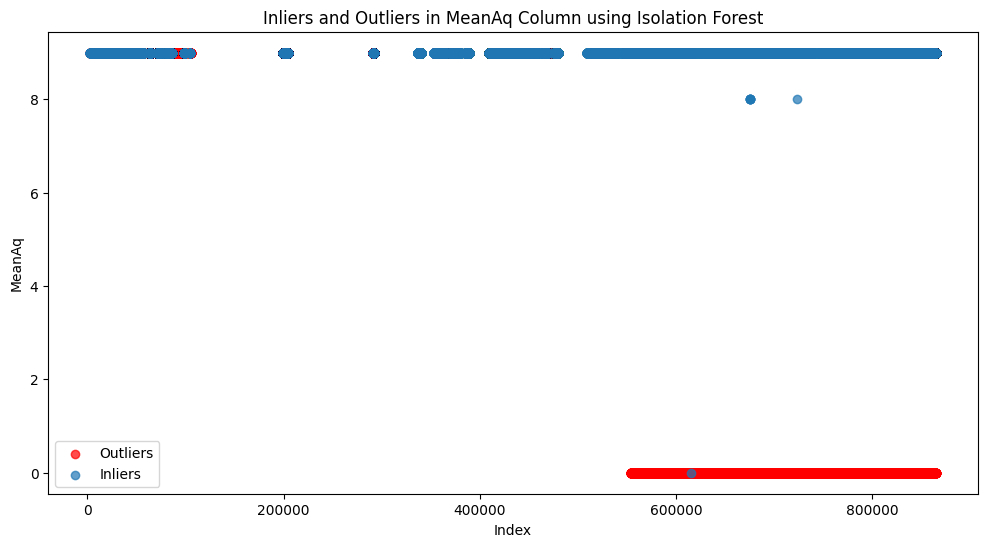

In [ ]:
  tr,vl,te=preprocess(df2)
  outliers, inliers =  isolated_forest(tr, "auto")
  # you can try with 0.1, 0.01 etc

In [ ]:
df3 = inliers

df_mode = fill_null_values_by_mode(df3)
df_median = fill_null_values_by_median(df3)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)

# tr,vl,te=preprocess(df_median)
# models_automated(tr,vl,"median")

# tr,vl,te=preprocess(df_median_std)
# models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

# tr,vl,te=preprocess(df_mode)
# models_automated(tr,vl,"mode")
# tr,vl,te=preprocess(df_mode_std)
# models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")

Model,dataset,mse,mae,mape
Linear,median_norm,0.0000417467,0.0049195983,0.0142863297
RandomForest,median_norm,0.0000008607,0.0003240430,0.0008461357
Xgboost,median_norm,0.0000087396,0.0021360741,0.0057328696
Model,dataset,mse,mae,mape
Linear,mode_norm,0.0000417467,0.0049195983,0.0142863297
RandomForest,mode_norm,0.0000008904,0.0003235697,0.0008450762
Xgboost,mode_norm,0.0000087396,0.0021360741,0.0057328696


In [ ]:
df3 = inliers
df3 = df3.drop(columns=["Depthm"])
df_mode = fill_null_values_by_mode(df3)
df_median = fill_null_values_by_median(df3)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)

# tr,vl,te=preprocess(df_median)
# models_automated(tr,vl,"median")

# tr,vl,te=preprocess(df_median_std)
# models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

# tr,vl,te=preprocess(df_mode)
# models_automated(tr,vl,"mode")
# tr,vl,te=preprocess(df_mode_std)
# models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")

Model,dataset,mse,mae,mape
Linear,median_norm,0.0000761063,0.0061676489,0.0176720037
RandomForest,median_norm,0.0000009059,0.0003334793,0.0008709253
Xgboost,median_norm,0.0000080596,0.0020463008,0.0054669890
Model,dataset,mse,mae,mape
Linear,mode_norm,0.0000761063,0.0061676489,0.0176720037
RandomForest,mode_norm,0.0000008816,0.0003321940,0.0008672762
Xgboost,mode_norm,0.0000080596,0.0020463008,0.0054669890


In [ ]:
df3 = inliers
df3 = df3[['T_degC','Salnty','STheta','O2Sat']]
df_mode = fill_null_values_by_mode(df3)
df_median = fill_null_values_by_median(df3)
df_mode_std = standardized_columns(df_mode)
df_median_std = standardized_columns(df_median)
df_mode_norm = normalize_columns(df_mode)
df_median_norm = normalize_columns(df_median)

# tr,vl,te=preprocess(df_median)
# models_automated(tr,vl,"median")

# tr,vl,te=preprocess(df_median_std)
# models_automated(tr,vl,"median_std")

tr,vl,te=preprocess(df_median_norm)
models_automated(tr,vl,"median_norm")

# tr,vl,te=preprocess(df_mode)
# models_automated(tr,vl,"mode")
# tr,vl,te=preprocess(df_mode_std)
# models_automated(tr,vl,"mode_std")
tr,vl,te=preprocess(df_mode_norm)
models_automated(tr,vl,"mode_norm")

Model,dataset,mse,mae,mape
Linear,median_norm,0.0001263688,0.0086930097,0.0261963780
RandomForest,median_norm,0.0000004678,0.0003058904,0.0008245615
Xgboost,median_norm,0.0000065151,0.0019075053,0.0052087321
Model,dataset,mse,mae,mape
Linear,mode_norm,0.0001263688,0.0086930097,0.0261963780
RandomForest,mode_norm,0.0000004244,0.0003039437,0.0008219958
Xgboost,mode_norm,0.0000065151,0.0019075053,0.0052087321
